## SWE spherical FVM triangular mesh

### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import matplotlib.tri as mtri
from matplotlib.colors import Normalize


from scipy.io import loadmat
from scipy.optimize import root_scalar


import time

from itertools import product, combinations

### Generate mesh

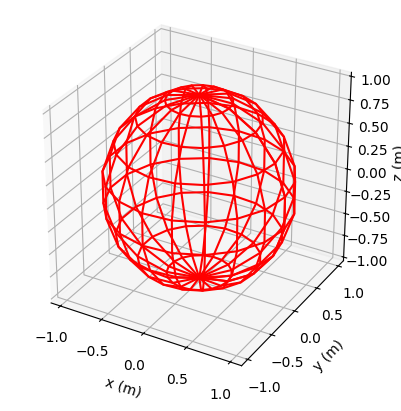

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.plot_wireframe(x, y, z, color="r")

plt.show()

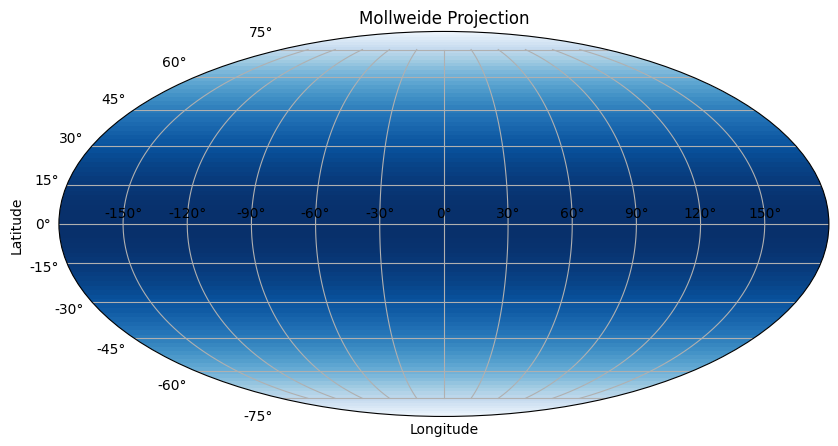

In [3]:
# Create grid of latitude (phi) and longitude (theta)
phi, theta = np.mgrid[-np.pi/2:np.pi/2:100j, 0:2*np.pi:200j]  # phi: latitude, theta: longitude

# Convert to cartesian coordinates (optional, for comparison with 3D)
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Map to Mollweide projection
#longitude = theta # Keep range
longitude = theta - np.pi  # Shift range to [-π, π]
#latitude = phi - np.pi / 2  # Shift range to [-π/2, π/2]
latitude = phi

# Plot the Mollweide projection
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")

# Convert latitude and longitude to radians for Mollweide
ax.pcolormesh(longitude, latitude, z, shading='auto', cmap='Blues')  # Color by z-values
ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Mollweide Projection")
plt.show()



### Functions

In [4]:
def randomly_rotate(points):
    """
    Apply a random rotation to a set of 3D points.
    """
    random_rotation_matrix = np.linalg.qr(np.random.randn(3, 3))[0]
    return np.dot(random_rotation_matrix, points)

def get_icosahedral_mesh():
    """
    Generate an icosahedral mesh.
    Returns:
        P (numpy.ndarray): 3x12 array of vertex positions.
        tri (numpy.ndarray): 20x3 array of triangle indices.
    """
    phi = (1 + np.sqrt(5)) / 2
    P = np.array([
        [-1,  phi,  0],
        [ 1,  phi,  0],
        [-1, -phi,  0],
        [ 1, -phi,  0],
        [ 0, -1,  phi],
        [ 0,  1,  phi],
        [ 0, -1, -phi],
        [ 0,  1, -phi],
        [ phi,  0, -1],
        [ phi,  0,  1],
        [-phi,  0, -1],
        [-phi,  0,  1],
    ]).T

    # Normalize vertices to lie on the unit sphere
    P = P / np.linalg.norm(P, axis=0)

    # Center the vertices around the origin
    P = P - np.mean(P, axis=1, keepdims=True)

    # Apply a random rotation
    P = randomly_rotate(P)

    tri = np.array([
        [1, 12, 6],
        [1, 6, 2],
        [1, 2, 8],
        [1, 8, 11],
        [1, 11, 12],
        [2, 6, 10],
        [6, 12, 5],
        [12, 11, 3],
        [11, 8, 7],
        [8, 2, 9],
        [4, 10, 5],
        [4, 5, 3],
        [4, 3, 7],
        [4, 7, 9],
        [4, 9, 10],
        [5, 10, 6],
        [3, 5, 12],
        [7, 3, 11],
        [9, 7, 8],
        [10, 9, 2]
    ]) - 1  # Convert 1-based indexing to 0-based

    return P, tri


def plot_icosahedral_mesh(P, tri):
    """
    Plot an icosahedral mesh using Matplotlib.
    Args:
        P (numpy.ndarray): 3x12 array of vertex positions.
        tri (numpy.ndarray): 20x3 array of triangle indices.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the trisurf plot
    ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, edgecolor='k', linewidth=0.5, alpha=0.8)

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes

    # Set axis limits for better visualization
    limit = 1.2
    ax.set_xlim([-limit, limit])
    ax.set_ylim([-limit, limit])
    ax.set_zlim([-limit, limit])

    # Turn off the grid and axis for a cleaner look (optional)
    ax.grid(False)
    ax.axis('off')

    plt.show()

def refine_mesh(Pin, triin):
    """
    Refine a triangular mesh by subdividing each triangle into smaller triangles.
    Args:
        Pin (numpy.ndarray): 3xN array of vertex positions.
        triin (numpy.ndarray): Mx3 array of triangle indices.

    Returns:
        P (numpy.ndarray): Refined 3xN array of vertex positions.
        tri (numpy.ndarray): Refined Mx3 array of triangle indices.
    """
    N = Pin.shape[1]  # Number of vertices in the original mesh

    # Step 1: Generate all edges for each triangle
    edges_1 = triin[:, [0, 1]]  # Edges between vertices 0 and 1
    edges_2 = triin[:, [1, 2]]  # Edges between vertices 1 and 2
    edges_3 = triin[:, [2, 0]]  # Edges between vertices 2 and 0

    # Combine all edges and sort each edge to ensure consistent order
    edges = np.vstack([edges_1, edges_2, edges_3])
    edges_sorted = np.sort(edges, axis=1)

    # Step 2: Find unique edges and their indices
    edges_unique, unique_indices = np.unique(edges_sorted, axis=0, return_inverse=True)

    # Step 3: Create new vertices at the midpoints of unique edges
    Pnew = (Pin[:, edges_unique[:, 0]] + Pin[:, edges_unique[:, 1]]) / 2
    Pnew = Pnew / np.linalg.norm(Pnew, axis=0, keepdims=True)  # Normalize to unit sphere

    # Step 4: Map triangle edges to new vertices
    idx1 = unique_indices[:len(triin)]            # Indices for edges_1
    idx2 = unique_indices[len(triin):2*len(triin)]  # Indices for edges_2
    idx3 = unique_indices[2*len(triin):]          # Indices for edges_3

    # Step 5: Generate new triangles
    tri = np.vstack([
        np.column_stack([triin[:, 0], N + idx1, N + idx3]),
        np.column_stack([triin[:, 1], N + idx2, N + idx1]),
        np.column_stack([triin[:, 2], N + idx3, N + idx2]),
        np.column_stack([N + idx1, N + idx2, N + idx3])
    ])

    # Step 6: Combine original and new vertices
    P = np.hstack([Pin, Pnew])

    return P, tri


In [5]:
def compute_EToE(EToV):
    """
    Compute the Element-to-Element (EToE) connectivity for a triangular mesh.
    The EToE[i, j] will give the neighboring element (triangle) for the j-th face of element i.

    Parameters:
        EToV: numpy array of shape (n_elements, 3)
              Each row represents a triangle defined by 3 vertices.

    Returns:
        EToE: numpy array of shape (n_elements, 3)
              EToE[i, j] gives the neighboring triangle index for the j-th face
              of triangle i, or -1 if the face is on the boundary.
    """
    n_elements = EToV.shape[0]
    n_faces = 3  # Triangles have 3 faces

    # Create a dictionary to store edges and their corresponding triangles/faces
    edge_to_element = {}

    # Helper function to sort edges
    def sorted_edge(v1, v2):
        return tuple(sorted((v1, v2)))

    # Populate the edge-to-element mapping
    for elem in range(n_elements):
        for face in range(n_faces):
            # Define the vertices of the current face
            v1, v2 = EToV[elem, face], EToV[elem, (face + 1) % n_faces]
            edge = sorted_edge(v1, v2)

            if edge not in edge_to_element:
                edge_to_element[edge] = []
            edge_to_element[edge].append((elem, face))

    # Initialize the EToE table with -1 (indicating boundary edges)
    EToE = -np.ones((n_elements, n_faces), dtype=int)

    # Populate the EToE table using the edge-to-element mapping
    for edge, connections in edge_to_element.items():
        if len(connections) == 2:
            # If two triangles share the edge, they are neighbors
            (elem1, face1), (elem2, face2) = connections
            EToE[elem1, face1] = elem2
            EToE[elem2, face2] = elem1

    # Rotate the rows of EToE to shift the columns as needed
    EToE = np.roll(EToE, shift=-1, axis=1)
    
    return EToE

### Functions FVM SWE

In [45]:
def spherical_coordinates(x, y, z):
    """
    Convert Cartesian coordinates to spherical coordinates.
    Args:
        x (numpy.ndarray): x-coordinates.
        y (numpy.ndarray): y-coordinates.
        z (numpy.ndarray): z-coordinates.
    Returns:0
        r (numpy.ndarray): Radial distance.
        theta (numpy.ndarray): Azimuthal angle.
        phi (numpy.ndarray): Polar angle.
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y, x)
    phi = np.arccos(z / r)
    return r, theta, phi

def spherical_unit_vectors(x, y, z):
    """
    Compute the spherical unit vectors for given Cartesian coordinates.
    
    Args:
        x, y, z (numpy.ndarray): Cartesian coordinates.
        
    Returns:
        e_theta (numpy.ndarray): Azimuthal unit vector.
        e_phi (numpy.ndarray): Polar unit vector.
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    
    e_theta = np.array([-np.sin(theta) * np.cos(phi), 
                        -np.sin(theta) * np.sin(phi), 
                        np.cos(theta)])
    
    e_phi = np.array([-np.sin(phi), 
                      np.cos(phi), 
                      0])
    
    return e_theta, e_phi



def face_normal_spherical(EToV, P, i):
    """
    Compute the normal vector for each edge of the triangle in spherical coordinates (theta, phi).
    Args:
        EToV (numpy.ndarray): Element to vertex mapping.
        P (numpy.ndarray): Coordinates of the vertices.
        i (int): Index of the triangle.
    Returns:
        normals (list): List of tuples (theta, phi) for each face (3 per triangle).
    """

    vertices = EToV[i]  # Get the vertex indices for the current triangle
    neighbors = EToE[i]
    
    # Get the Cartesian coordinates of the vertices
    x0, y0, z0 = P[:, vertices[0]]
    x1, y1, z1 = P[:, vertices[1]]
    x2, y2, z2 = P[:, vertices[2]]

    # Calculate the edge vectors in Cartesian coordinates
    e0 = np.array([x2 - x1, y2 - y1, z2 - z1])  # Edge 0 (v1, v2)
    e1 = np.array([x0 - x2, y0 - y2, z0 - z2])  # Edge 1 (v2, v0)
    e2 = np.array([x1 - x0, y1 - y0, z1 - z0])  # Edge 2 (v0, v1)

    # Calculate the edge vectors in spherical coordinates
    _, theta0, phi0 = spherical_coordinates(x0, y0, z0)
    _, theta1, phi1 = spherical_coordinates(x1, y1, z1)
    _, theta2, phi2 = spherical_coordinates(x2, y2, z2)

    # Calculate the edge vectors in spherical coordinates
    sph_e0 = np.array([theta2 - theta1, phi2 - phi1])  # Edge 0 (v1, v2)
    sph_e1 = np.array([theta0 - theta2, phi0 - phi2])  # Edge 1 (v2, v0)
    sph_e2 = np.array([theta1 - theta0, phi1 - phi0])  # Edge 2 (v0, v1)

    # Calculate length of the edge vectors
    len_e0 = np.linalg.norm(sph_e0)
    len_e1 = np.linalg.norm(sph_e1)
    len_e2 = np.linalg.norm(sph_e2)
    len_e = [len_e0, len_e1, len_e2]

    # Normalize the edge vectors
    sph_e0 = sph_e0 / np.linalg.norm(sph_e0)
    sph_e1 = sph_e1 / np.linalg.norm(sph_e1)
    sph_e2 = sph_e2 / np.linalg.norm(sph_e2)

    #print(f'Edge 0: {sph_e0}')
    #print(f'Edge 1: {sph_e1}')
    #print(f'Edge 2: {sph_e2}')

    # Rotate the edge vectors by 90 degrees to get the normal vectors
    n0 = np.array([-sph_e0[1], sph_e0[0]])  # Normal 0 (v1, v2)
    n1 = np.array([-sph_e1[1], sph_e1[0]])  # Normal 1 (v2, v0)
    n2 = np.array([-sph_e2[1], sph_e2[0]])  # Normal 2 (v0, v1)

    return len_e, n0, n1, n2


In [65]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G


def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, dt, len):
    #smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * len/dt * (QR - QL)
    return F


In [172]:
def plot_icosahedral_water_level(P, tri, Q_all, idx):
    
    # Plot the initial water level
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111, projection='3d')
    #cmap = 'Blues'
    # Create a custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list('light_blue_to_coolwarm', ['lightblue', 'blue'], N=256)
    collec = ax.plot_trisurf(P[0, :], P[1, :], P[2, :], triangles=tri, cmap=cmap, edgecolor='k', linewidth=0.5, alpha=0.8)
    collec.set_array(Q_all[idx][:, 0])
    collec.autoscale()

    # Add colorbar
    plt.colorbar(collec, ax=ax, shrink=0.5, aspect=5, pad=0.1, label='Water Level (m)')

    # Set title
    ax.set_title('Initial condition: Water level h (m)')

    #ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for 3D
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Distance y (m)')
    ax.set_zlabel('Distance z (m)')

    plt.show()
    return

## Icosahedral

P shape: (3, 12), tri shape: (20, 3)
P shape: (3, 42), tri shape: (80, 3)
P shape: (3, 162), tri shape: (320, 3)


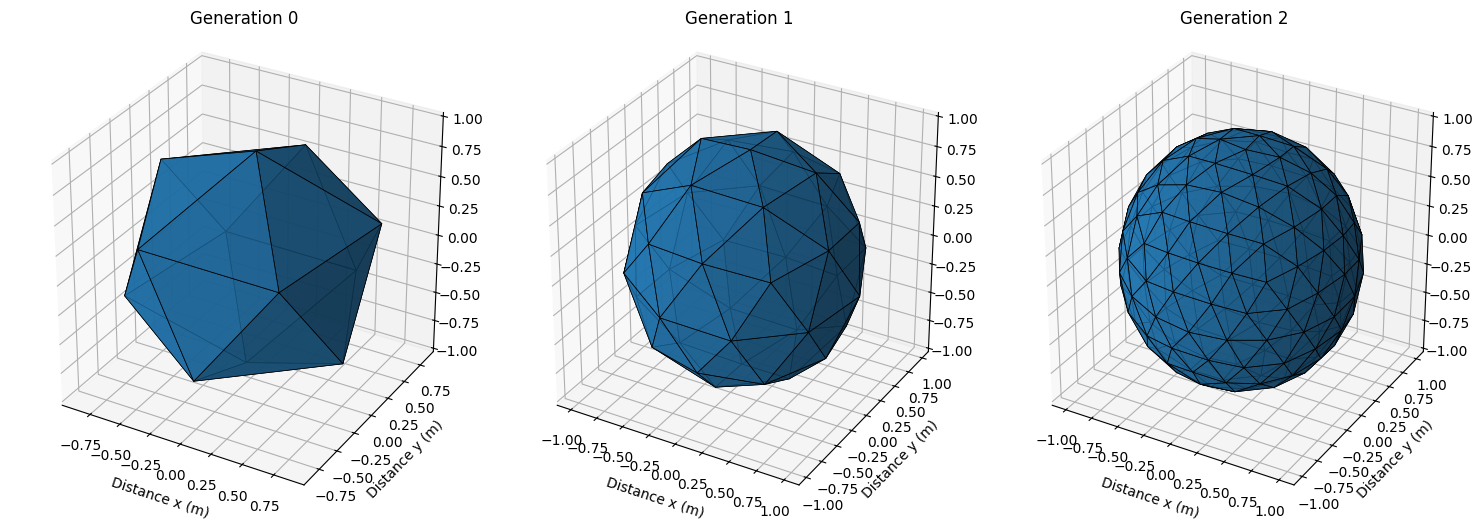

In [234]:
# Generate the initial icosahedral mesh
P, tri = get_icosahedral_mesh()

# Prepare for refinement generations
generations = 3
meshes = [(P, tri)]  # Store the meshes for each generation

# Generate refined meshes for each generation
for _ in range(generations):
    print(f'P shape: {P.shape}, tri shape: {tri.shape}')
    P, tri = refine_mesh(P, tri)
    meshes.append((P, tri))

# Create subplots to visualize the first three generations
fig = plt.figure(figsize=(15, 5))
for i in range(generations):
    ax = fig.add_subplot(1, generations, i + 1, projection='3d')
    P, tri = meshes[i]
    ax.plot_trisurf(
        P[0, :], P[1, :], P[2, :],
        triangles=tri,
        edgecolor='k',
        linewidth=0.5,
        alpha=0.8
    )
    ax.set_title(f"Generation {i}")
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for 3D
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Distance y (m)')
   # ax.axis('off')  # Turn off axis for clarity

# Display the subplots
plt.tight_layout()
#plt.savefig('Plots/icosahedral_mesh_refinement.pdf', format='pdf')
plt.show()

In [235]:
def Flux_theta(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the theta-direction  
    F[:, 0] = Q[:, 1]
    F[:, 1] =  Q[:, 1]**2 / Q[:, 0] + 0.5 * g * Q[:, 0]**2
    F[:, 2] = Q[:, 1] * Q[:, 2] / Q[:, 0]

    return F

def Flux_phi(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the phi-direction
    G[:, 0] = Q[:, 2]
    G[:, 1] = Q[:, 1] * Q[:, 2] / Q[:, 0]
    G[:, 2] = Q[:, 2]**2 / Q[:, 0] + 0.5 * g * Q[:, 0]**2
    
    return G

Number of triangles: 320
Number of vertices: 162
Triangle: 179 with neighbors: [259 239 125]
Neighbor 0: 259
Neighbor 1: 239
Neighbor 2: 125


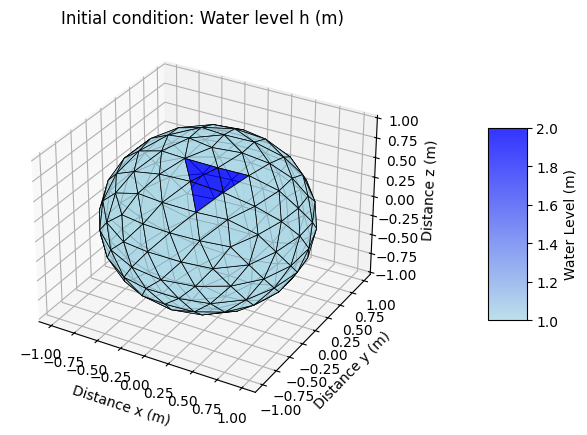

In [420]:
N_triangles = tri.shape[0]
N_vertices = P.shape[1]
print(f'Number of triangles: {N_triangles}')
print(f'Number of vertices: {N_vertices}')

Q = np.zeros((N_triangles, 3))
# Set initial overall water level to 1 m
Q[:, 0] = 1
Q.shape

EToV = tri
EToE = compute_EToE(EToV)
# Define inital water level
h0 = 2

# Triangle with initial high water level
idx = 179
print(f'Triangle: {idx} with neighbors: {EToE[idx]}')
# Set initial water level for idx and the surrounding triangles
Q[idx, 0] = h0
for j in range(3):
    neighbor = EToE[idx, j]
    print(f'Neighbor {j}: {neighbor}')
    if neighbor != -1:
        Q[neighbor, 0] = h0

Q_all = [Q]

# Plot the initial water level
plot_icosahedral_water_level(P, tri, Q_all, 0)

In [421]:
Q.shape, N_triangles

((320, 3), 320)

In [422]:
def LF(QL, QR, FL, FR, dt, len):
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)

    F = 0.5 * (FR + FL) - 0.5 * len/dt * (QR - QL)
    return F

In [434]:
EToV = tri

# Initialize
Q = np.zeros((N_triangles, 3))
# Set initial overall water level to 1 m
Q[:, 0] = 1
Q.shape

EToV = tri
EToE = compute_EToE(EToV)
# Define inital water level
h0 = 2

# Triangle with initial high water level
idx = 179
print(f'Triangle: {idx} with neighbors: {EToE[idx]}')
# Set initial water level for idx and the surrounding triangles
Q[idx, 0] = h0
for j in range(3):
    neighbor = EToE[idx, j]
    Q[neighbor, 0] = h0

t = 0
tend = 0.01
dt = 0.0025 # Time step
CFL = 0.9

# Initialize lists for storing the water levels and time steps
Q_all = [Q]
t_all = [t]

Qnew = np.copy(Q)

# Start timer
start_time = time.time()

# Time loop
while t < tend:
    print(f't = {t:.4f}')
    if t + dt > tend:
        dt = tend - t

    # MUSCL part
    Q_t = np.zeros_like(Q)

    # Compute the fluxes
    F_theta, F_phi = Flux_theta(Q), Flux_phi(Q)
    #print(f'F_theta: {F_theta.shape}, F_phi: {F_phi.shape}')

    # Loop through each triangle
    for i in range(N_triangles):
        # Extract element data
        vertices = EToV[i]
        neighbors = EToE[i]

        # Compute the normal vectors for the current face
        len_e, n0, n1, n2 = face_normal_spherical(EToV, P, i)
        #print(f'Normal 0: {n0}, Normal 1: {n1}, Normal 2: {n2}')
        normals = [n0, n1, n2]

        # Get cartesian coordinates of the vertices
        x0, y0, z0 = P[:, vertices[0]]
        x1, y1, z1 = P[:, vertices[1]]
        x2, y2, z2 = P[:, vertices[2]]

        # Calculate the are of the triangle
        triangle_area = 0.5 * np.linalg.norm(np.cross([x1 - x0, y1 - y0, z1 - z0], [x2 - x0, y2 - y0, z2 - z0]))
        
        # Compute fluxes
        fluxes = []
        for f in range(3): # Loop through each face
            #print(f'Face: {f}')
            neighbor = EToE[i, f]
            #print(f'Neighbor: {neighbor}')

            # Numerical fluxes in theta-direction
            F_t = LF(Q[i], Q[neighbor], F_theta[i], F_theta[neighbor], dt, len_e[f])
            
            # Numerical fluxes in phi-direction
            G_t = LF(Q[i], Q[neighbor], F_phi[i], F_phi[neighbor], dt, len_e[f])

            # Collect the fluxes in one array
            fluxes_t = np.array([F_t, G_t])

            # Correct the fluxes with the normal vectors
            flux_normal = np.dot(normals[f], fluxes_t)

            # Store the corrected fluxes
            fluxes.append(flux_normal)

        # Update Qnew for triangle i
        Qnew[i] = Q[i] - dt/(triangle_area+1) * sum(len_e[f] * fluxes[f] for f in range(3))
        
    # Update Q and time
    t += dt
    Qnew[:, 0] = np.maximum(1e-10, Qnew[:, 0])
    Q = np.copy(Qnew)

    # Store the water levels and time steps
    Q_all.append(Q)
    t_all.append(t)

n = len(Q_all)
print(f'Number of time steps: {n}')

# Stop timer
end_time = time.time()
print(f'Time elapsed: {end_time - start_time:.4f} seconds')


Triangle: 179 with neighbors: [259 239 125]
t = 0.0000
t = 0.0025
t = 0.0050
t = 0.0075
Number of time steps: 5
Time elapsed: 0.2297 seconds


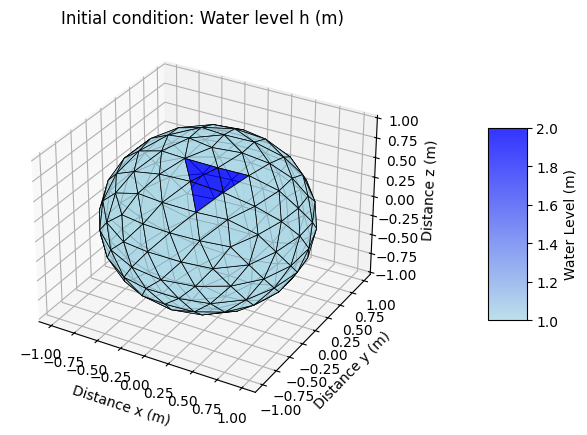

In [450]:
plot_icosahedral_water_level(P, tri, Q_all, 0)

In [443]:
np.max(Q_all[0][:, 0])

np.float64(2.0)

In [445]:
np.max(Q_all[2][:, 0])

np.float64(2.5314597201988813)

### Mollweide.. 

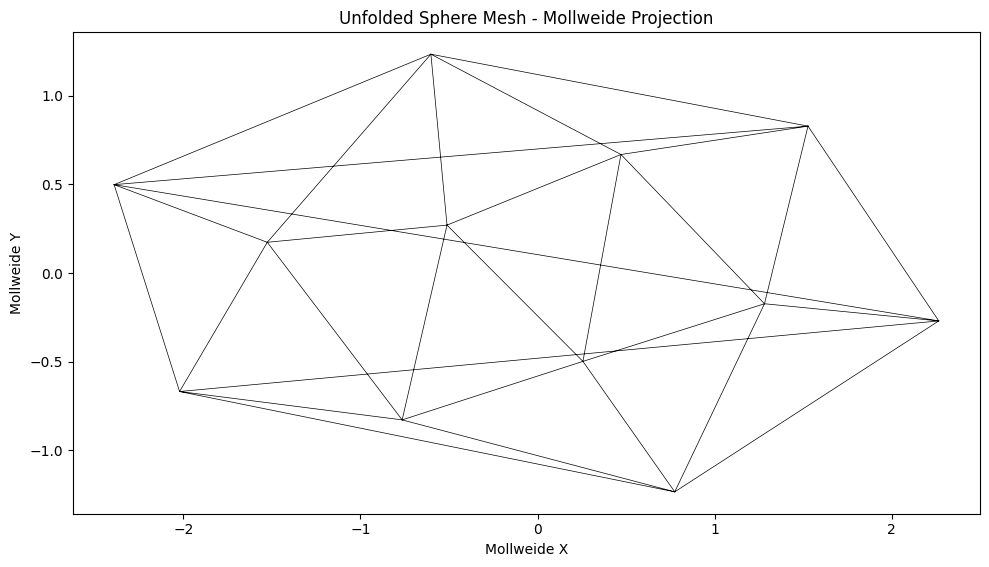

In [16]:
# Generate the initial icosahedral mesh
P, tri = get_icosahedral_mesh()

# Prepare for refinement generations
generations = 0
meshes = [(P, tri)]  # Store the meshes for each generation

# Generate refined meshes for each generation
for _ in range(generations):
    print(f'P shape: {P.shape}, tri shape: {tri.shape}')
    P, tri = refine_mesh(P, tri)
    meshes.append((P, tri))


# Function to calculate theta (auxiliary latitude) for Mollweide projection
def mollweide_aux_lat(lat):
    def equation(theta, lat):
        return 2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)
    
    # Solve numerically for theta
    theta = root_scalar(equation, args=(lat,), bracket=[-np.pi/2, np.pi/2]).root
    return theta

# Mollweide projection function
def mollweide_projection(x, y, z):
    lon = np.arctan2(y, x)  # Longitude
    lat = np.arcsin(z)      # Latitude

    # Compute auxiliary latitude (theta) for each latitude value
    theta = np.array([mollweide_aux_lat(lat_i) for lat_i in lat])

    # Compute Mollweide x and y
    x_moll = 2 * np.sqrt(2) * lon * np.cos(theta) / np.pi
    y_moll = np.sqrt(2) * np.sin(theta)

    return x_moll, y_moll

# Convert 3D points (x, y, z) to Mollweide coordinates
x, y, z = P[0, :], P[1, :], P[2, :]
x_moll, y_moll = mollweide_projection(x, y, z)

# Create a 2D triangulation for Mollweide coordinates
triangulation = mtri.Triangulation(x_moll, y_moll, tri)

# Plot the unfolded triangles in the Mollweide projection
fig, ax = plt.subplots(figsize=(10, 6))
ax.triplot(triangulation, color='k', linewidth=0.5)  # Draw triangle edges
ax.set_title("Unfolded Sphere Mesh - Mollweide Projection")
ax.set_xlabel("Mollweide X")
ax.set_ylabel("Mollweide Y")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [17]:
print(tri.shape, P.shape)
no_triangles = tri.shape[0]
no_vertices = P.shape[1]
print(f"Number of triangles: {no_triangles}")
print(f"Number of vertices: {no_vertices}")
EToE = compute_EToE(tri)

# Print the EToE table
print("EToE Connectivity Table:")
print(EToE)

(20, 3) (3, 12)
Number of triangles: 20
Number of vertices: 12
EToE Connectivity Table:
[[ 6  1  4]
 [ 5  2  0]
 [ 9  3  1]
 [ 8  4  2]
 [ 7  0  3]
 [15 19  1]
 [16 15  0]
 [17 16  4]
 [18 17  3]
 [19 18  2]
 [15 11 14]
 [16 12 10]
 [17 13 11]
 [18 14 12]
 [19 10 13]
 [ 5  6 10]
 [ 6  7 11]
 [ 7  8 12]
 [ 8  9 13]
 [ 9  5 14]]


### Define and plot initial conditions: X, Y, Z

In [18]:
# Global constants
g = 9.81  # gravity
N_theta = 200
N_phi = 100
thetaL, thetaR = 0, 2*np.pi # Longitude
phiL, phiR = 0, np.pi # Latitude
t = 0
tend = 0.5 # 1 
CFL = 0.8

d_theta = (thetaR - thetaL) / N_theta
d_phi = (phiR - phiL) / N_phi

theta = np.linspace(0, 2 * np.pi - d_theta, N_theta)  # Starting at 0 for theta
phi = np.linspace(0, np.pi - d_phi, N_phi)           # Starting at 0 for phi

# Center
theta_center = 3*np.pi/2
phi_center = np.pi/8

# Width
sigma = np.pi/16 # Assuming the same width in both directions

# Create the meshgrid
THETA, PHI = np.meshgrid(theta, phi)

r = 1

# Convert to Cartesian coordinates
X = r * np.sin(PHI) * np.cos(THETA)
Y = r * np.sin(PHI) * np.sin(THETA)
Z = r * np.cos(PHI)
print(f"Shape of X, Y, Z: {X.shape}")

def Gaussian_2D(theta, phi, theta_center, phi_center, sigma, h0=3):
    return 1 + h0 * np.exp( - ((theta - theta_center)**2/ (2*sigma**2) + (phi - phi_center)**2 / (2*sigma**2)))

H =  Gaussian_2D(THETA, PHI, theta_center, phi_center, sigma)
print(f"Shape of H: {H.shape}")

norm = mcolors.Normalize(vmin=H.min(), vmax=H.max())
colors = cm.Blues(norm(H))
colors.shape

Shape of X, Y, Z: (100, 200)
Shape of H: (100, 200)


(100, 200, 4)

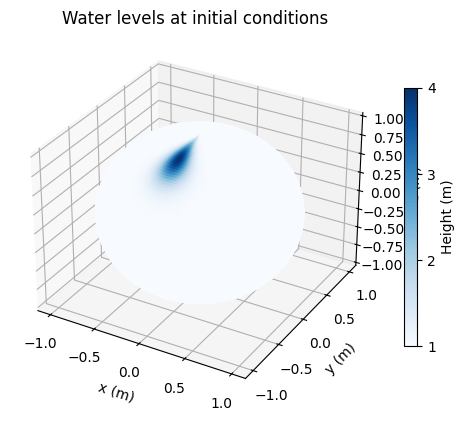

In [19]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=colors, alpha=0.8, rstride=1, cstride=1, shade=False)

# Add a color bar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.Blues), ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Height (m)')
cbar.set_ticks([1, 2, 3, 4])
cbar.set_ticklabels([1, 2, 3, 4])

# Set the aspect ratio to be equal
#ax.set_box_aspect([1, 1, 1]) # Equal aspect ratio for all axes

# Set titles and labels
ax.set_title(f'Water levels at initial conditions')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
#ax.view_init(elev=22.5, azim=45+210)

plt.show()

## Plot initial condition Mollweide

In [20]:
# Global constants
g = 9.81  # gravity
N_theta = 200
N_phi = 100
thetaL, thetaR = 0, 2*np.pi # Longitude
phiL, phiR = -np.pi/2, np.pi/2 # Latitude
t = 0
tend = 0.5 # 1 
CFL = 0.8

d_theta = (thetaR - thetaL) / N_theta
d_phi = (phiR - phiL) / N_phi

# Define the grid
theta = np.linspace(0, 2 * np.pi - d_theta, N_theta)  # Starting at 0 for theta
phi = np.linspace(phiL, phiR - d_phi, N_phi)           # Starting at 0 for phi

# Center
theta_center = np.pi
phi_center = -np.pi/3

# Width
sigma = np.pi/16 # Assuming the same width in both directions

# Create the meshgrid
THETA, PHI = np.meshgrid(theta, phi)

r = 1

# Convert to Cartesian coordinates
X = r * np.sin(PHI) * np.cos(THETA)
Y = r * np.sin(PHI) * np.sin(THETA)
Z = r * np.cos(PHI)
print(f"Shape of X, Y, Z: {X.shape}")

# Initial 
Q = np.zeros((3, N_phi, N_theta))
Qnew = np.copy(Q)

def Gaussian_2D(theta, phi, theta_center, phi_center, sigma, h0=3):
    return 1 + h0 * np.exp( - ((theta - theta_center)**2/ (2*sigma**2) + (phi - phi_center)**2 / (2*sigma**2)))

H =  Gaussian_2D(THETA, PHI, theta_center, phi_center, sigma)
print(f"Shape of H: {H.shape}")

Q[0, :, :] = H

Shape of X, Y, Z: (100, 200)
Shape of H: (100, 200)


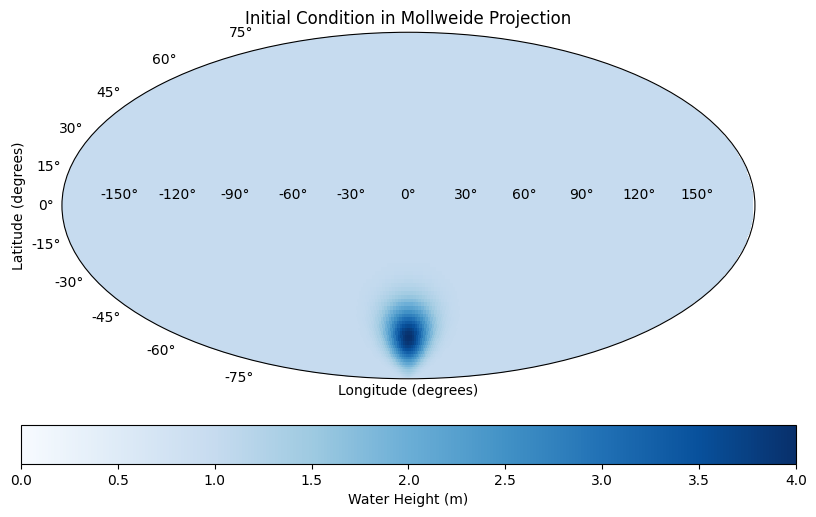

In [21]:
# Set up the Mollweide projection plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Normalize longitude (theta) to [-pi, pi] for Mollweide
theta_mollweide = THETA - np.pi
phi_mollweide = PHI

# Plot the data using pcolormesh
c = ax.pcolormesh(
    theta_mollweide, phi_mollweide, H,
    cmap='Blues',
    shading='auto',
    vmin = 0, vmax = 4
    )

# Add a colorbar
cb = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.1)
cb.set_label('Water Height (m)')

# Add labels
ax.set_title("Initial Condition in Mollweide Projection")
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Latitude (degrees)")

# Add labels and format ticks
#ax.set_xticks(np.linspace(-np.pi, np.pi, 5))  # Set longitude ticks
#ax.set_xticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])  # Format longitude labels
#ax.set_yticks(np.linspace(-np.pi/2, np.pi/4, 3))  # Set latitude ticks
#ax.set_yticklabels([r"$-\pi/2$", "0", r"$\pi/2$"])  # Format latitude labels

plt.show()

### Plot initial conditions by triangle

(3, 12) (20, 3)
(20,)
(20, 4)


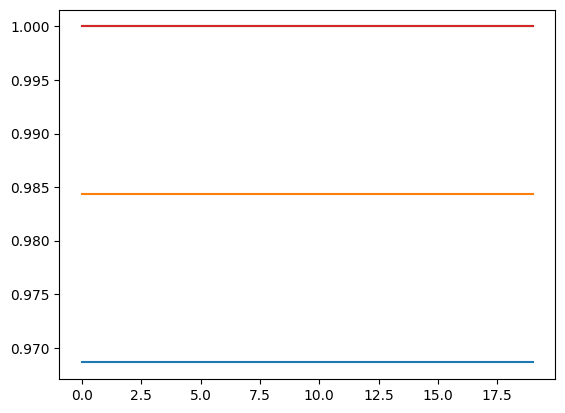

In [22]:
print(P.shape, tri.shape)
water_levels = np.ones(tri.shape[0]) # Calculate water level for each triangle
#water_levels[2:4] = 2 # Set water level for some triangles to 2
print(water_levels.shape)

# Normalize triangle values for color mapping
norm = mcolors.Normalize(vmin=water_levels.min(), vmax=water_levels.max())
triangle_colors = cm.Blues(norm(water_levels))

#norm = mcolors.Normalize(vmin=water_levels.min(), vmax=water_levels.max())
#triangle_colors = cm.Blues(water_levels)
print(triangle_colors.shape)
plt.plot(triangle_colors)
plt.show()

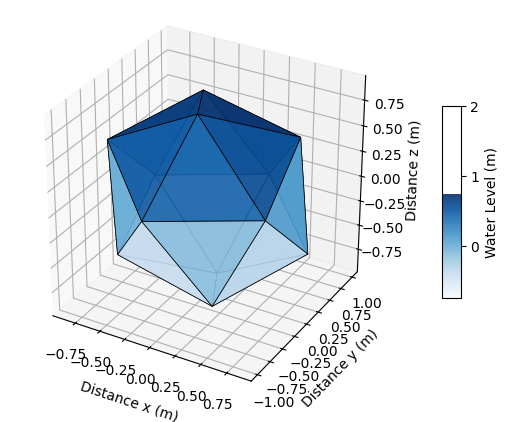

In [23]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh with assigned face colors
#face_colors = plt.cm.Blues(water_levels / np.max(water_levels))

# Use the scalar field (water_levels) to define face colors directly
surf = ax.plot_trisurf(
    P[0, :], P[1, :], P[2, :],
    triangles=tri,  # Triangle connectivity
    cmap='Blues',  # Colormap for the surface
    edgecolor='k',   # Optional: Triangle edges
    linewidth=0.5,
    alpha=0.9,
    shade=False,     # Disable shading for accurate coloring
    antialiased=True,
    facecolors=triangle_colors,  # Map water levels to colors
)

#ax.tricontourf(P[0, :], P[1, :], P[2, :], tri, water_levels, cmap='Blues', alpha=0.5)

# Add a colorbar for water levels
colorbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
colorbar.set_label('Water Level (m)')
colorbar.set_ticks([0, 1, 2])
colorbar.set_ticklabels([0, 1, 2])

ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for 3D
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('Distance z (m)')
plt.show()


### Loop over triangles

In [24]:

from scipy.spatial import Delaunay

triangles=Delaunay(np.array([X.flatten(), Y.flatten()]).T)


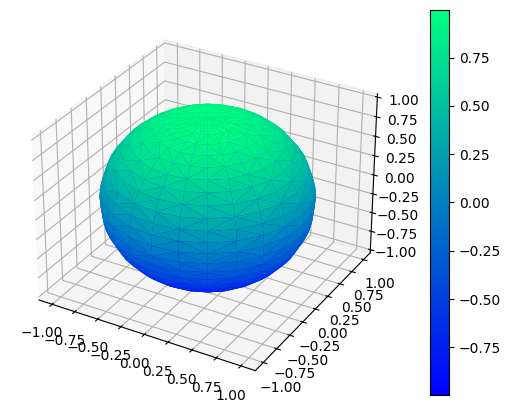

In [25]:
# Defining variables
a = np.linspace(0, 2 * np.pi,25)
b = np.linspace(0, np.pi, 25)
[X, Y] = np.meshgrid(a, b)
x = np.outer(np.cos(a), np.sin(b))
y = np.outer(np.sin(a), np.sin(b))
z = np.outer(np.ones_like(a), np.cos(b))
# Creating figure and 3D axes
fig = plt.figure(figsize =(9, 5))
ax = plt.axes(projection ='3d')
# Creating plot
ax.plot_trisurf(x.flatten(), y.flatten(), z.flatten(),
                triangles=Delaunay(np.array([X.flatten(), Y.flatten()]).T).simplices,
                cmap='winter')

# Add color bar
plt.colorbar(ax.plot_trisurf(x.flatten(), y.flatten(), z.flatten(),
                            triangles=Delaunay(np.array([X.flatten(), Y.flatten()]).T).simplices,
                            cmap='winter'), ax=ax)
# show plot
plt.show()